---
## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

### step 1 camera calibration and distortion
this step I will follow the function in Udacity class

* Find corners.In this step I will use function <font color=red>findChessboardCorners() </font> and <font color=red>drawChessboardCorners()</font>. you can get more information in [cv2.findChessboardCorners](https://docs.opencv.org/2.4/modules/calib3d/doc/camera_calibration_and_3d_reconstruction.html#cv2.findChessboardCorners) and [cv2.drawChessboardCorners](https://docs.opencv.org/2.4/modules/calib3d/doc/camera_calibration_and_3d_reconstruction.html#cv2.drawChessboardCorners). At the same time,save the imgpoint and the corners.
* Calibrating Camera. In this step, I will use the function <font color=red>cv2.calibrateCamera() </font>. 
* Correcting for Distortion. In this step, I will use the function of opencv  <font color=red>cv2.undistort() </font>.

In [1]:
import numpy as np
import pickle
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
from collections import deque
%matplotlib inline

In [2]:
def find_corners(img,nx=9,ny=6,show=True):
    '''
    this function just for find corners in img. return corners
    '''
    ##read imgae
    image = cv2.imread(img)
    original = image # save original image
    ##convert to gray
    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    # Find the chessboard corner
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
     # If found, draw corners
    if ret == True and show == True:
       # Draw and display the corners
        cv2.drawChessboardCorners(image, (nx, ny), corners, ret)
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
        ax1.set_title('Original Image', fontsize=18)
        ax1.imshow(cv2.cvtColor(cv2.imread(img),cv2.COLOR_BGR2RGB))#must be cv2.imread(img),if it is the original , the result is tha same as image
        ax2.set_title("After finding corners",fontsize=18)
        ax2.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
    return ret,corners


(True, array([[[  99.22319794,  269.60043335]],
 
        [[ 119.55948639,  268.01455688]],
 
        [[ 140.10562134,  266.09640503]],
 
        [[ 161.32537842,  264.46206665]],
 
        [[ 183.27304077,  262.50640869]],
 
        [[ 206.09098816,  260.30386353]],
 
        [[ 230.66191101,  258.20678711]],
 
        [[ 256.18832397,  256.33599854]],
 
        [[ 282.2003479 ,  254.34809875]],
 
        [[ 100.64093781,  303.31674194]],
 
        [[ 119.97882843,  301.88937378]],
 
        [[ 139.44282532,  300.53918457]],
 
        [[ 160.4808197 ,  299.51983643]],
 
        [[ 181.76586914,  298.32415771]],
 
        [[ 206.11979675,  296.93075562]],
 
        [[ 231.07981873,  295.81002808]],
 
        [[ 256.54135132,  294.62661743]],
 
        [[ 282.715271  ,  293.25354004]],
 
        [[ 100.58176422,  336.47460938]],
 
        [[ 119.23699951,  335.98181152]],
 
        [[ 139.12606812,  335.36663818]],
 
        [[ 159.70048523,  334.86010742]],
 
        [[ 181.78625488,  

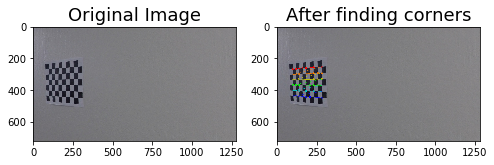

In [3]:
images = glob.glob('camera_cal/calibration*.jpg')
##test find corners
find_corners(images[2])

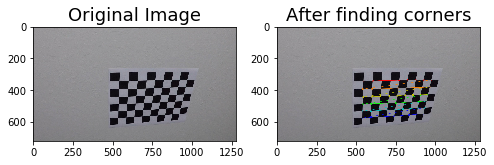

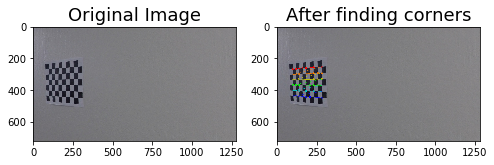

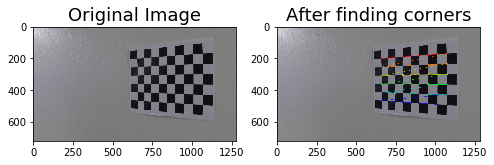

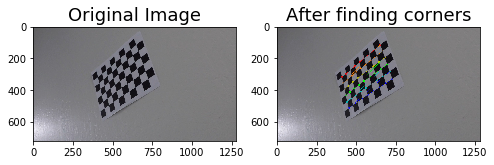

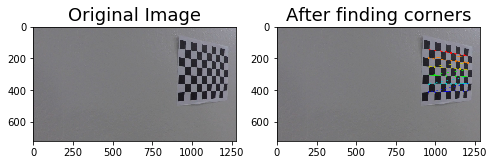

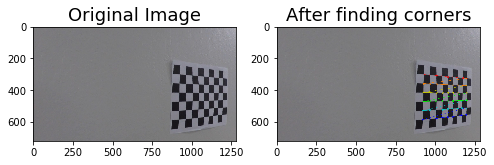

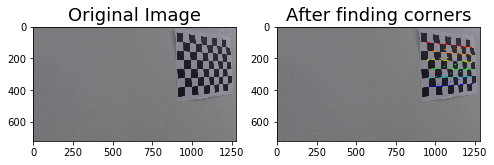

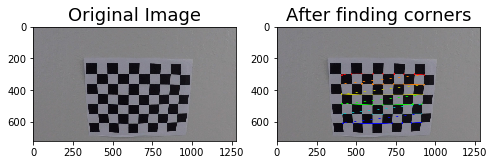

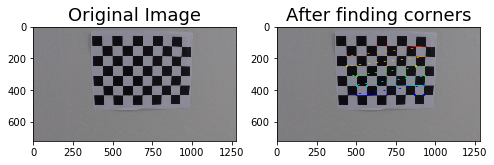

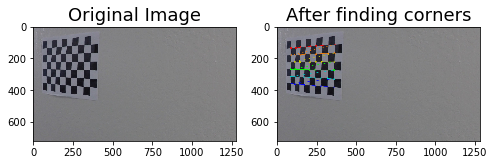

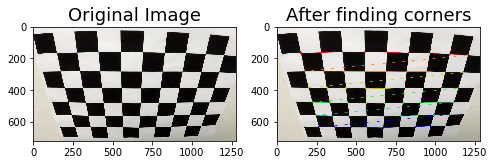

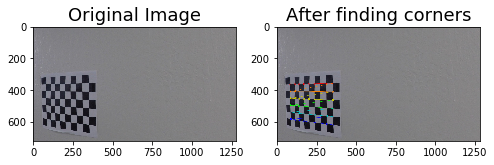

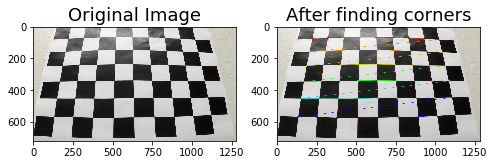

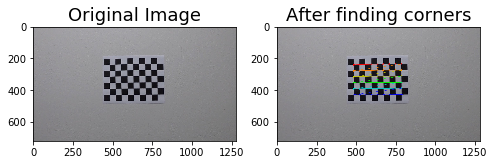

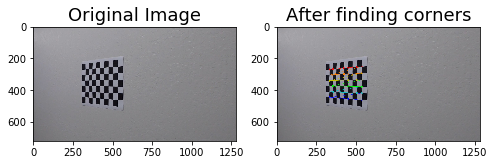

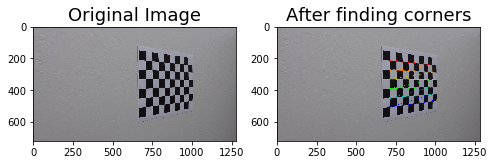

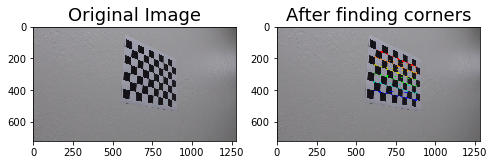

In [4]:
##find all corners in image
nx = 9
ny = 6
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2) #like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)

objpoints = [] #3D point in real world
imgpoints = [] # 2d points in image plane.

for image in images:
    ret,corners = find_corners(image)
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

Calibrate Camera using function cv2.calibrateCamera and correcting distortion image

In [5]:
##calibrateCamera  and cv2.undistort
def undistort(img,show=True):
    image = cv2.imread(img)
    img_size = (image.shape[1],image.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    undist = cv2.undistort(image, mtx, dist, None, mtx)
    if show==True:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
        ax1.set_title("original",fontsize=18)
        ax1.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
        ax2.set_title("undistort",fontsize=18)
        ax2.imshow(cv2.cvtColor(undist,cv2.COLOR_BGR2RGB))
    return undist

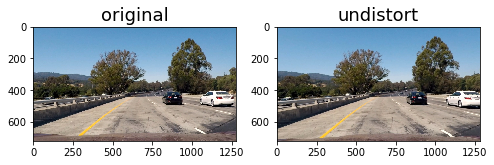

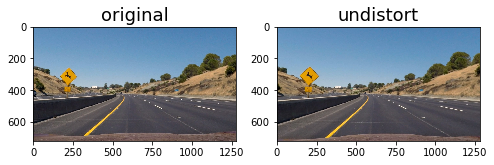

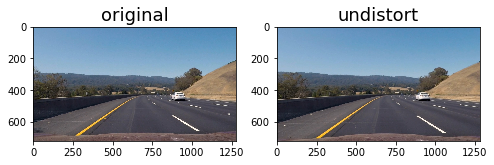

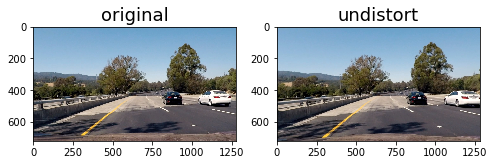

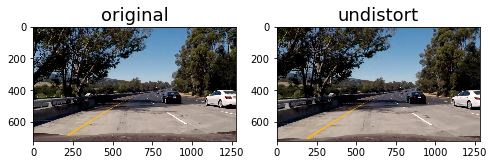

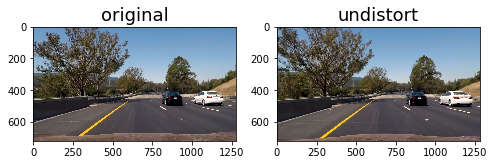

In [6]:
##test for all images
test_images = glob.glob("test_images/test*.jpg")
for image in test_images:
    undistort(image)

### Step 2: Perspective Transform

In this step I will define a function `birds_eye()` which transforms the undistorted image to a "birds eye view" of the road which focuses only on the lane lines. In this step, I will use the function  <font color=red>cv2.getPerspectiveTransform(src, dst)</font> and warp the image using the function <font color=red>cv2.warpPerspective</font>.

In [7]:
##define the function of perspective transform
src_interest_area = np.float32([[490, 482],[810, 482],
                      [1250, 720],[40, 720]])
def birds_eye(img,src,show=True):
    undist = undistort(img, show = False)
    img_size = (undist.shape[1], undist.shape[0])
   #print(img_size) (1280,720)
    offset=0
    #ret,corners = find_corners(img,show=False)
    #sometimes it can not be find corners
    src = src
    dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                                     [img_size[0]-offset, img_size[1]-offset], 
                                     [offset, img_size[1]-offset]])
            # d) use cv2.getPerspectiveTransform() to get M, the transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
            # e) use cv2.warpPerspective() to warp your image to a top-down view
    warped = cv2.warpPerspective(undist, M, img_size)
    
    if show:
        f,(ax1,ax2) = plt.subplots(1,2,figsize=(8,4))
        ax1.set_title('original',fontsize=18)
        ax1.imshow(cv2.cvtColor(undist,cv2.COLOR_BGR2RGB))
        ax2.set_title("perspective",fontsize=18)
        ax2.imshow(cv2.cvtColor(warped,cv2.COLOR_BGR2RGB))
    return warped

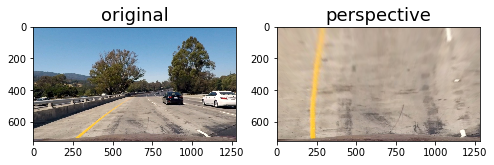

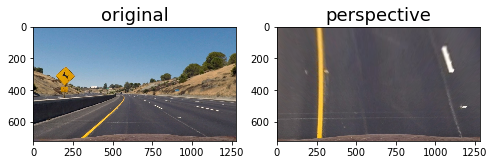

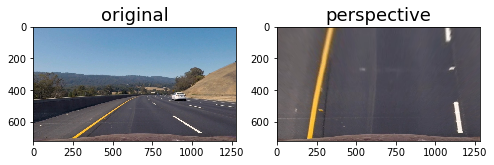

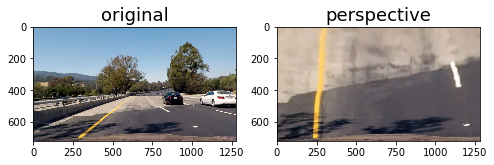

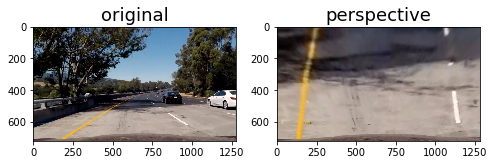

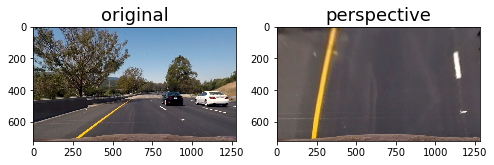

In [8]:
##test for bird_eye
##test_images = glob.glob("test/*.jpg")

for image in test_images:
    birds_eye(image,src_interest_area)
    

### Step 3: Combining Thresholds，including the color and gradient

In this step I will do operation to get more information of the image.
* Calculate gradient.including the directional gradient, gradient magnitude,gradient direction, these function just for removing the noise
* Get clearer color channel

In [9]:
# Calculate directional gradient
def abs_sobel_thresh(gray, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Apply x or y gradient
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    elif orient == 'y':
    	sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute values
    sobel = np.absolute(sobel)
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*sobel/np.max(sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel > thresh[0]) & (scaled_sobel < thresh[1])] = 1
    # Return the result
    return binary_output

# Calculate gradient magnitude
def mag_thresh(gray, sobel_kernel=3, mag_thresh=(0, 255)):
    # Apply x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    sobel = np.sqrt(sobelx ** 2 + sobely ** 2)
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*sobel/np.max(sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel > mag_thresh[0]) & (scaled_sobel < mag_thresh[1])] = 1
    # Return the result
    return binary_output

# Calculate gradient direction
def dir_threshold(gray, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Apply x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Error statement to ignore division and invalid errors
    with np.errstate(divide='ignore', invalid='ignore'):
        absgraddir = np.absolute(np.arctan(sobely/sobelx))
        dir_binary =  np.zeros_like(absgraddir)
        dir_binary[(absgraddir > thresh[0]) & (absgraddir < thresh[1])] = 1
    # Return the result
    return dir_binary

In [10]:
##def the pipeline
def pipeline(img,show=True):
    '''
    this function just for the features including the color and gradient in image. but you need to apply the perspective transform firstly.
    that function is birds_eye
    '''
    ##apply camera and undistort and perspective transform
    warped = birds_eye(img,src_interest_area,show=False)
    # Convert to HLS color space and separate the S channel
    hls = cv2.cvtColor(warped, cv2.COLOR_BGR2HLS)
    s = hls[:,:,2]
    # Grayscale image
    gray = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)
    # Define sobel kernel size
    ksize = 5
    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(gray, orient='x', sobel_kernel=ksize, thresh=(10, 255))
    grady = abs_sobel_thresh(gray, orient='y', sobel_kernel=ksize, thresh=(60, 255))
    mag_binary = mag_thresh(gray, sobel_kernel=ksize, mag_thresh=(40, 255))
    dir_binary = dir_threshold(gray, sobel_kernel=ksize, thresh=(.65, 1.05))
    # Combine all the thresholding information
    #combined is the thresholding of gradient
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1#here
    # Threshold color channel
    s_binary = np.zeros_like(combined)
    s_binary[(s > 160) & (s < 255)] = 1
    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors    
    color_binary = np.zeros_like(combined)
    color_binary[(s_binary > 0) | (combined > 0)] = 1
    
    if show:
        f,(ax1,ax2,ax3,ax4,ax5) = plt.subplots(1,5,figsize=(18,9))
        ax1.set_title("original",fontsize=14)
        ax1.imshow(cv2.cvtColor(cv2.imread(img),cv2.COLOR_BGR2RGB))
        ax2.set_title("birds_eye",fontsize=14)
        ax2.imshow(cv2.cvtColor(warped,cv2.COLOR_BGR2RGB))
        ax3.set_title('gradient combined',fontsize=14)
        ax3.imshow(combined,cmap='gray')
        ax4.set_title("s channel",fontsize=14)
        ax4.imshow(s_binary,cmap='gray')
        ax5.set_title("color&gra combined",fontsize=14)
        ax5.imshow(color_binary,cmap="gray")
    return color_binary

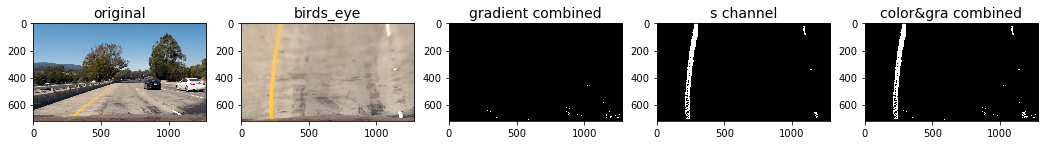

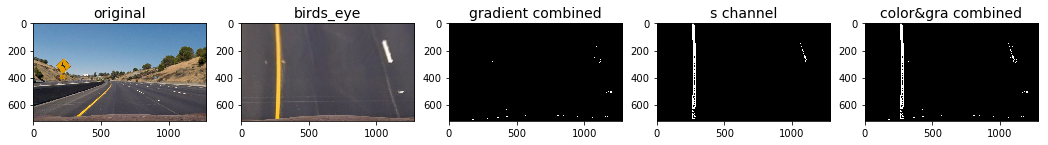

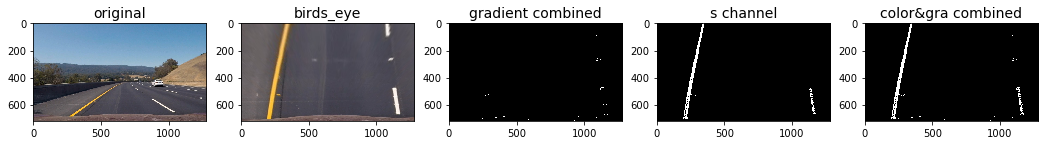

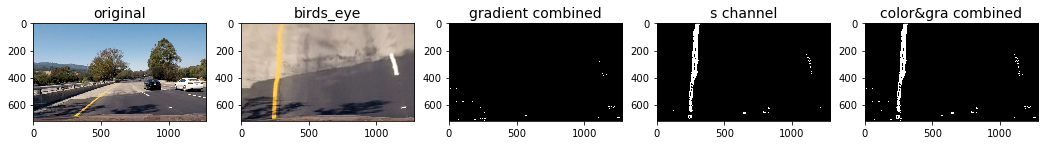

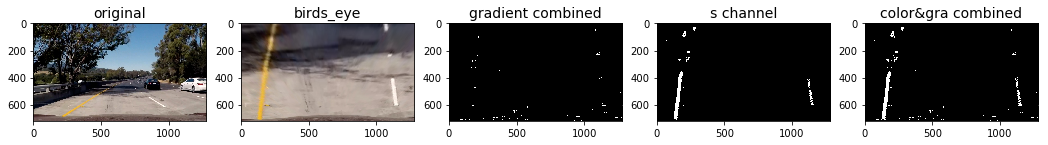

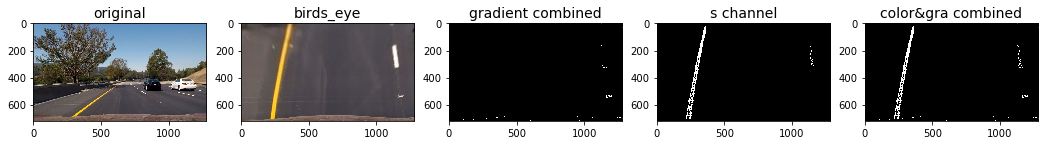

In [11]:
##test for pipeline
##test_images = glob.glob("test/*.jpg")
for image in test_images:
    pipeline(image)

----
### step 4：  Determine the curvature of the lane and vehicle position with respect to center

In this step I will do operation to  find the lane using the slide window search and determine the curvature
* Find the lines using the slide windows
* Measuring Curvature

In [12]:
# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image
def find_line(image,show = True):
    binary_warped = pipeline(image)
    #print(binary_warped[binary_warped.shape[0]//2:,:])
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)  ## must change the / to // ,this show the 
    print(histogram)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    print(nonzero)#return two arrays ,one for the index nonzero of rows, two for cols
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    #the euqation
    #the value of y is changing
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    ##display
    if show:
        # Generate x and y values for plotting

        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        plt.imshow(out_img)
        plt.title("after fit",fontsize=12)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        
    # Measure Radius of Curvature for each lane line,change to real wworld
    ym_per_pix = 30./720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meteres per pixel in x dimension
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    left_curverad = ((1 + (2*left_fit_cr[0]*np.max(lefty) + left_fit_cr[1])**2)**1.5) \
                                 /np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*np.max(lefty) + right_fit_cr[1])**2)**1.5) \
                                    /np.absolute(2*right_fit_cr[0])
   # Now our radius of curvature is in meters
    print(left_curverad, 'm', right_curverad, 'm')
    
   #draw the result
    offset = 0 
    img_size = (binary_warped.shape[1], binary_warped.shape[0])
    src = np.float32([[490, 482],[810, 482],
                      [1250, 720],[40, 720]])
    dst = np.float32([[0, 0], [1280, 0], 
                     [1250, 720],[40, 720]])
    Minv = cv2.getPerspectiveTransform(dst, src)
   # ploty = np.linspace(0, 719, num=720)
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    pts_left = np.array([np.flipud(np.transpose(np.vstack([left_fitx, ploty])))])
    pts_right = np.array([np.transpose(np.vstack([right_fitx, ploty]))])
    pts = np.hstack((pts_left, pts_right))
    cv2.polylines(color_warp, np.int_([pts]), isClosed=False, color=(0,0,255), thickness = 40)
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    newwarp = cv2.warpPerspective(color_warp, Minv, (binary_warped.shape[1], binary_warped.shape[0]))
    result = cv2.addWeighted(mpimg.imread(image), 1, newwarp, 0.5, 0)
    
    plt.imshow(result)
    plt.title("result",fontsize=12)
    

[ 0.  0.  0. ...,  1.  0.  0.]
(array([  0,   0,   0, ..., 716, 716, 717], dtype=int64), array([273, 274, 275, ..., 965, 966, 927], dtype=int64))
1782.62036516 m 19433.6782518 m
[ 0.  0.  0. ...,  0.  0.  0.]
(array([  0,   0,   0, ..., 716, 716, 717], dtype=int64), array([255, 256, 257, ..., 961, 962, 965], dtype=int64))
2764.97371842 m 8255.75721154 m
[ 0.  0.  0. ...,  0.  0.  0.]
(array([  0,   0,   0, ..., 718, 718, 718], dtype=int64), array([335, 336, 337, ..., 927, 928, 929], dtype=int64))
2502.59310786 m 4786.36386523 m
[ 0.  0.  0. ...,  0.  0.  0.]
(array([  0,   0,   0, ..., 718, 718, 718], dtype=int64), array([287, 288, 289, ..., 657, 658, 921], dtype=int64))
4172.94336209 m 2558048.74041 m
[ 0.  1.  1. ...,  9.  6.  0.]
(array([ 11,  11,  11, ..., 718, 718, 718], dtype=int64), array([218, 219, 220, ..., 965, 966, 967], dtype=int64))
2444.4107454 m 2137.58775979 m
[ 0.  0.  0. ...,  1.  0.  0.]
(array([  1,   1,   2, ..., 718, 718, 718], dtype=int64), array([1121, 1122, 112

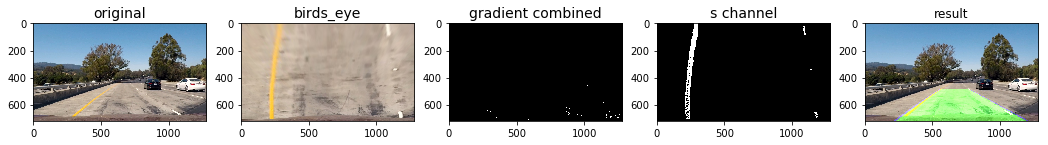

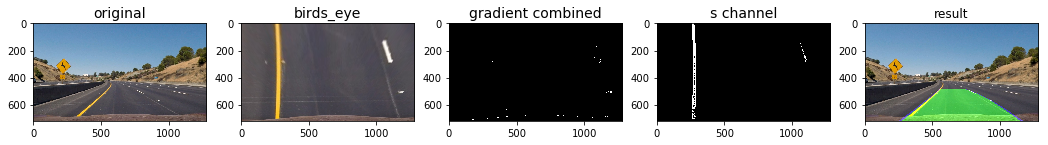

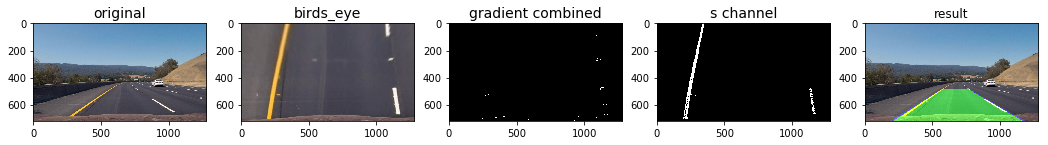

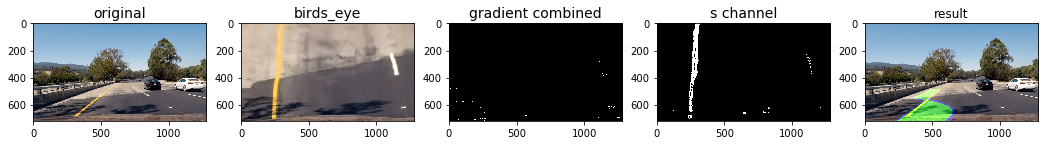

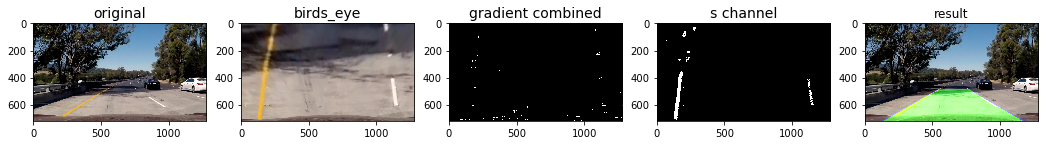

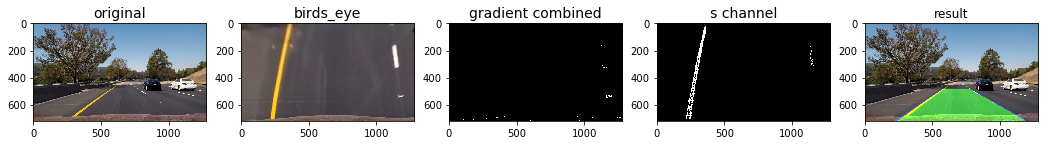

In [13]:
#for all test images
for image in test_images:
    find_line(image,show=False)

---
### step 5：Video Processing Pipeline:

* Just use the class 'Line' in Udacity lesson to keep tracking.actually.
* Definition the function to calculate the curvature in real world
* 

In [14]:
# Define a class to receive the characteristics of each line detection
class Line:
    def __init__(self):
        # Was the line found in the previous frame?
        self.found = False
        
        # Remember x and y values of lanes in previous frame
        self.X = None
        self.Y = None
        
        # Store recent x intercepts for averaging across frames
        self.x_int = deque(maxlen=10)
        self.top = deque(maxlen=10)
        
        # Remember previous x intercept to compare against current one
        self.lastx_int = None
        self.last_top = None
        
        # Remember radius of curvature
        self.radius = None
        
        # Store recent polynomial coefficients for averaging across frames
        self.fit0 = deque(maxlen=10)
        self.fit1 = deque(maxlen=10)
        self.fit2 = deque(maxlen=10)
        self.fitx = None
        self.pts = []
        
        # Count the number of frames
        self.count = 0
        
    def found_search(self, x, y):
        '''
        This function is applied when the lane lines have been detected in the previous frame.
        It uses a sliding window to search for lane pixels in close proximity (+/- 25 pixels in the x direction)
        around the previous detected polynomial. 
        '''
        xvals = []
        yvals = []
        if self.found == True: 
            i = 720
            j = 630
            while j >= 0:
                yval = np.mean([i,j])
                xval = (np.mean(self.fit0))*yval**2 + (np.mean(self.fit1))*yval + (np.mean(self.fit2))
                x_idx = np.where((((xval - 25) < x)&(x < (xval + 25))&((y > j) & (y < i))))
                x_window, y_window = x[x_idx], y[x_idx]
                if np.sum(x_window) != 0:
                    np.append(xvals, x_window)
                    np.append(yvals, y_window)
                i -= 90
                j -= 90
        if np.sum(xvals) == 0: 
            self.found = False # If no lane pixels were detected then perform blind search
        return xvals, yvals, self.found
    
    def blind_search(self, x, y, image):
        '''
        This function is applied in the first few frames and/or if the lane was not successfully detected
        in the previous frame. It uses a slinding window approach to detect peaks in a histogram of the
        binary thresholded image. Pixels in close proimity to the detected peaks are considered to belong
        to the lane lines.
        '''
        xvals = []
        yvals = []
        if self.found == False: 
            i = 720
            j = 630
            while j >= 0:
                histogram = np.sum(image[j:i,:], axis=0)
                if self == Right:
                    peak = np.argmax(histogram[640:]) + 640
                else:
                    peak = np.argmax(histogram[:640])
                x_idx = np.where((((peak - 25) < x)&(x < (peak + 25))&((y > j) & (y < i))))
                x_window, y_window = x[x_idx], y[x_idx]
                if np.sum(x_window) != 0:
                    xvals.extend(x_window)
                    yvals.extend(y_window)
                i -= 90
                j -= 90
        if np.sum(xvals) > 0:
            self.found = True
        else:
            yvals = self.Y
            xvals = self.X
        return xvals, yvals, self.found
    
    def radius_of_curvature(self, xvals, yvals):
        ym_per_pix = 30./720 # meters per pixel in y dimension
        xm_per_pix = 3.7/700 # meteres per pixel in x dimension
        fit_cr = np.polyfit(yvals*ym_per_pix, xvals*xm_per_pix, 2)
        curverad = ((1 + (2*fit_cr[0]*np.max(yvals) + fit_cr[1])**2)**1.5) \
                                     /np.absolute(2*fit_cr[0])
        return curverad
    
    def sort_vals(self, xvals, yvals):
        sorted_index = np.argsort(yvals)#return the sorted result index
        sorted_yvals = yvals[sorted_index]
        sorted_xvals = xvals[sorted_index]
        return sorted_xvals, sorted_yvals
    
    def get_intercepts(self, polynomial):
        '''
        get the intercept of this polynomial,when x= 0
        '''
        bottom = polynomial[0]*720**2 + polynomial[1]*720 + polynomial[2]
        top = polynomial[0]*0**2 + polynomial[1]*0 + polynomial[2]
        return bottom, top
    
    

this function is for the pipeline processing the vedio

In [17]:
# Video Processing Pipeline
def process_vid(image):
    img_size = (image.shape[1], image.shape[0])
    # Gaussian Blur
    kernel_size = 5
    img = cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)
    # Calibrate camera and undistort image
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    
    img_size = (undist.shape[1], undist.shape[0])
   #print(img_size) (1280,720)
    offset=0
    #ret,corners = find_corners(img,show=False)
    #sometimes it can not be find corners
    src = src_interest_area
    dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                                     [img_size[0]-offset, img_size[1]-offset], 
                                     [offset, img_size[1]-offset]])
    #  use cv2.getPerspectiveTransform() to get M, the transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    #  use cv2.warpPerspective() to warp your image to a top-down view
    warped = cv2.warpPerspective(undist, M, img_size)
    
    # Convert to HLS color space and separate the S channel
    hls = cv2.cvtColor(warped, cv2.COLOR_BGR2HLS)
    s = hls[:,:,2]
    # Grayscale image
    gray = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)
    # Define sobel kernel size
    ksize = 5
    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(gray, orient='x', sobel_kernel=ksize, thresh=(10, 255))
    grady = abs_sobel_thresh(gray, orient='y', sobel_kernel=ksize, thresh=(60, 255))
    mag_binary = mag_thresh(gray, sobel_kernel=ksize, mag_thresh=(40, 255))
    dir_binary = dir_threshold(gray, sobel_kernel=ksize, thresh=(.65, 1.05))
    # Combine all the thresholding information
    #combined is the thresholding of gradient
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1#here
    # Threshold color channel
    s_binary = np.zeros_like(combined)
    s_binary[(s > 160) & (s < 255)] = 1
    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors    
    combined_binary = np.zeros_like(combined)
    combined_binary[(s_binary > 0) | (combined > 0)] = 1
    
    
    # Identify all non zero pixels in the image
    x, y = np.nonzero(np.transpose(combined_binary)) #return two arrays ,one for rows, another for cols

    if Left.found == True: # Search for left lane pixels around previous polynomial
        leftx, lefty, Left.found = Left.found_search(x, y)
        
    if Right.found == True: # Search for right lane pixels around previous polynomial
        rightx, righty, Right.found = Right.found_search(x, y)

            
    if Right.found == False: # Perform blind search for right lane lines,first frame most use this
        rightx, righty, Right.found = Right.blind_search(x, y, combined_binary)
            
    if Left.found == False:# Perform blind search for left lane lines
        leftx, lefty, Left.found = Left.blind_search(x, y, combined_binary)

    lefty = np.array(lefty).astype(np.float32)
    leftx = np.array(leftx).astype(np.float32)
    righty = np.array(righty).astype(np.float32)
    rightx = np.array(rightx).astype(np.float32)
            
    # Calculate left polynomial fit based on detected pixels
    left_fit = np.polyfit(lefty, leftx, 2)
    
    # Calculate intercepts to extend the polynomial to the top and bottom of warped image
    leftx_int, left_top = Left.get_intercepts(left_fit)
    
    # Average intercepts across n frames
    Left.x_int.append(leftx_int)
    Left.top.append(left_top)
    leftx_int = np.mean(Left.x_int)
    left_top = np.mean(Left.top)
    Left.lastx_int = leftx_int
    Left.last_top = left_top
    
    # Add averaged intercepts to current x and y vals
    leftx = np.append(leftx, leftx_int)
    lefty = np.append(lefty, 720)
    leftx = np.append(leftx, left_top)
    lefty = np.append(lefty, 0)
    
    # Sort detected pixels based on the yvals
    leftx, lefty = Left.sort_vals(leftx, lefty)
    
    Left.X = leftx
    Left.Y = lefty
    
    # Recalculate polynomial with intercepts and average across n frames
    left_fit = np.polyfit(lefty, leftx, 2)
    Left.fit0.append(left_fit[0])
    Left.fit1.append(left_fit[1])
    Left.fit2.append(left_fit[2])
    left_fit = [np.mean(Left.fit0), 
                np.mean(Left.fit1), 
                np.mean(Left.fit2)]
    
    # Fit polynomial to detected pixels
    left_fitx = left_fit[0]*lefty**2 + left_fit[1]*lefty + left_fit[2]
    Left.fitx = left_fitx
    
    # Calculate right polynomial fit based on detected pixels
    right_fit = np.polyfit(righty, rightx, 2)

    # Calculate intercepts to extend the polynomial to the top and bottom of warped image
    rightx_int, right_top = Right.get_intercepts(right_fit)
    
    # Average intercepts across 5 frames
    Right.x_int.append(rightx_int)
    rightx_int = np.mean(Right.x_int)
    Right.top.append(right_top)
    right_top = np.mean(Right.top)
    Right.lastx_int = rightx_int
    Right.last_top = right_top
    rightx = np.append(rightx, rightx_int)
    righty = np.append(righty, 720)
    rightx = np.append(rightx, right_top)
    righty = np.append(righty, 0)
    
    # Sort right lane pixels
    rightx, righty = Right.sort_vals(rightx, righty)
    Right.X = rightx
    Right.Y = righty
    
    # Recalculate polynomial with intercepts and average across n frames
    right_fit = np.polyfit(righty, rightx, 2)
    Right.fit0.append(right_fit[0])
    Right.fit1.append(right_fit[1])
    Right.fit2.append(right_fit[2])
    right_fit = [np.mean(Right.fit0), np.mean(Right.fit1), np.mean(Right.fit2)]
    
    # Fit polynomial to detected pixels
    right_fitx = right_fit[0]*righty**2 + right_fit[1]*righty + right_fit[2]
    Right.fitx = right_fitx
        
    # Compute radius of curvature for each lane in meters
    left_curverad = Left.radius_of_curvature(leftx, lefty)
    right_curverad = Right.radius_of_curvature(rightx, righty)
        
    # Only print the radius of curvature every 3 frames for improved readability
    if Left.count % 3 == 0:
        Left.radius = left_curverad
        Right.radius = right_curverad
        
    # Calculate the vehicle position relative to the center of the lane
    position = (rightx_int+leftx_int)/2
    distance_from_center = abs((640 - position)*3.7/700) 
                
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    warp_zero = np.zeros_like(combined_binary).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    pts_left = np.array([np.flipud(np.transpose(np.vstack([Left.fitx, Left.Y])))])
    pts_right = np.array([np.transpose(np.vstack([right_fitx, Right.Y]))])
    pts = np.hstack((pts_left, pts_right))
    cv2.polylines(color_warp, np.int_([pts]), isClosed=False, color=(0,0,255), thickness = 40)
    cv2.fillPoly(color_warp, np.int_(pts), (34,255,34))
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0]))
    result = cv2.addWeighted(undist, 1, newwarp, 0.5, 0)
        
    # Print distance from center on video
    if position > 640:
        cv2.putText(result, 'Vehicle is {:.2f}m left of center'.format(distance_from_center), (100,80),
                 fontFace = 16, fontScale = 2, color=(255,255,255), thickness = 2)
    else:
        cv2.putText(result, 'Vehicle is {:.2f}m right of center'.format(distance_from_center), (100,80),
                 fontFace = 16, fontScale = 2, color=(255,255,255), thickness = 2)
    # Print radius of curvature on video
    cv2.putText(result, 'Radius of Curvature {}(m)'.format(int((Left.radius+Right.radius)/2)), (120,140),
             fontFace = 16, fontScale = 2, color=(255,255,255), thickness = 2)
    Left.count += 1
    return result

next for vedio processing

In [18]:
### Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
Left = Line()
Right = Line()
video_output = 'result.mp4'
clip1 = VideoFileClip("project_video.mp4").subclip(0,2)
white_clip = clip1.fl_image(process_vid) 
white_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video result.mp4
[MoviePy] Writing video result.mp4


 98%|████████████████████████████████████████████████████████████████████████████████▍ | 50/51 [01:47<00:02,  2.16s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: result.mp4 



In [19]:
HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format('result.mp4'))

the nest for challenge

In [20]:
Left = Line()
Right = Line()
video_output = 'challenge_result.mp4'
clip1 = VideoFileClip("challenge_video.mp4").subclip(0,2)
white_clip = clip1.fl_image(process_vid) 
white_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video challenge_result.mp4
[MoviePy] Writing video challenge_result.mp4


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [02:05<00:00,  2.00s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_result.mp4 



In [22]:
HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format('challenge_result.mp4'))